In [1]:
# Import packages and function
import pandas as pd
import polars as pl
#import os
#from datetime import datetime, timedelta
from ppclib import fetch_ppc_data, fetch_ppc_days_back, get_data_profile, combine_ppc_dataframe, blank_svid_ecid, get_parameter, param_spliting, combine

In [2]:
# Fetch PPC data from CIM api
start_date_str = "2025-04-03" # format "YYYY-MM-DD"
daysback = 7
ppc_file_list = fetch_ppc_days_back(start_date_str,daysback)

Skipping 2025-04-03 (file already exists)
Skipping 2025-04-02 (file already exists)
Skipping 2025-04-01 (file already exists)
Skipping 2025-03-31 (file already exists)
Skipping 2025-03-30 (file already exists)
Skipping 2025-03-29 (file already exists)
Skipping 2025-03-28 (file already exists)


In [3]:
# Import Data Profile Excel file name 'ProcessParasProfileUTL'
df4 = get_data_profile()

In [4]:
# Consolidate all 'PPCDataUTL' Excel files in working folder to one Polar dataframe
df3 = combine_ppc_dataframe(ppc_file_list)

Appended: D:/ppc_saw/myfolder/2025-04-03.xlsx done.
Schema([('EquipOpn', String), ('EquipID', String), ('ULotID', String), ('Recipe', String), ('Parameter', String), ('CreateTime', Datetime(time_unit='ms', time_zone=None)), ('EventID', String), ('EventDesc', String), ('SAW_ProductionStock_Z1', String), ('BladeOD_Z1', String), ('BladeThickness_Z1', String), ('FlangeODType_Z1', String), ('SAW_ProductionStock_Z2', String), ('BladeOD_Z2', String), ('BladeThickness_Z2', String), ('FlangeODType_Z2', String)])
Appended: D:/ppc_saw/myfolder/2025-04-02.xlsx done.
Schema([('EquipOpn', String), ('EquipID', String), ('ULotID', String), ('Recipe', String), ('Parameter', String), ('CreateTime', Datetime(time_unit='ms', time_zone=None)), ('EventID', String), ('EventDesc', String), ('SAW_ProductionStock_Z1', String), ('BladeOD_Z1', String), ('BladeThickness_Z1', String), ('FlangeODType_Z1', String), ('SAW_ProductionStock_Z2', String), ('BladeOD_Z2', String), ('BladeThickness_Z2', String), ('FlangeODTy

In [5]:
# Extract the parameters string from the 'parameter' column df3 to SVID and ECID dataframe
df3,SVID,ECID = param_spliting(df3)

Processing rows: 1717183it [00:26, 65665.40it/s]


In [6]:
# Memory release 
svid_rows = []
ecid_rows = []

In [7]:
# Join df3, SVID and ECID dataframe and combine to result polar dataframe
result = combine(df3,SVID,ECID)
#result.info()

In [8]:
# Anomaly Detection with Isolation Forest Code on result dataframe
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Initial cleaning
dfx = result.dropna(axis=1, how='all')          # Drop completely empty columns
dfx = dfx.dropna(axis=0, how='any')              # Drop rows with any missing values
df = dfx.drop(['CreateTime', 'CreateTimeUnix'], axis=1)  # Remove time columns

# Free Memory
result = []

# Preserve original categorical values before encoding
original_cat_columns = df.select_dtypes(include='object').copy()
encoded_df = df.copy()

# Label encode categorical columns
cat_cols = original_cat_columns.columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
    label_encoders[col] = le

# Train Isolation Forest and get scores
model = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)
model.fit(encoded_df)

# Get anomaly scores and normalize them to 0-1 range
scores = model.decision_function(encoded_df)
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(scores.reshape(-1, 1))

# Create results dataframe with original values and scores
encoded_df['AnomalyScore'] = scores  # Original scores (-0.5 to 0.5)
encoded_df['AnomalyScore_normalized'] = normalized_scores  # 0-1 scaled

results_df = pd.concat([
    encoded_df[['AnomalyScore', 'AnomalyScore_normalized']],
    dfx[['CreateTime','CreateTimeUnix']], original_cat_columns,
    df.select_dtypes(exclude='object')
], axis=1)

# Sort by anomaly score for better inspection
#results_df = results_df.sort_values('AnomalyScore_normalized', ascending=False)

# Extract anomalies with original values
anomalies_df = results_df[results_df['AnomalyScore_normalized'] > 0.5]  # Adjust threshold as needed
#print(f"Found {len(anomalies_df)} anomalies from {len(df)} total records")
#print("\nTop 5 anomalies:")
#print(anomalies_df.head())

# Verification metrics
print("\nScore Statistics:")
print(f"Mean score: {results_df.AnomalyScore_normalized.mean():.2f}")
print(f"Max score: {results_df.AnomalyScore_normalized.max():.2f}")
print(f"Min score: {results_df.AnomalyScore_normalized.min():.2f}")


Score Statistics:
Mean score: 0.85
Max score: 1.00
Min score: 0.00


In [9]:
# Free Memory
results_df = []

In [10]:
# anomalies_df.info()
anomalies_df.to_csv('anomaly_output.csv', index=False)

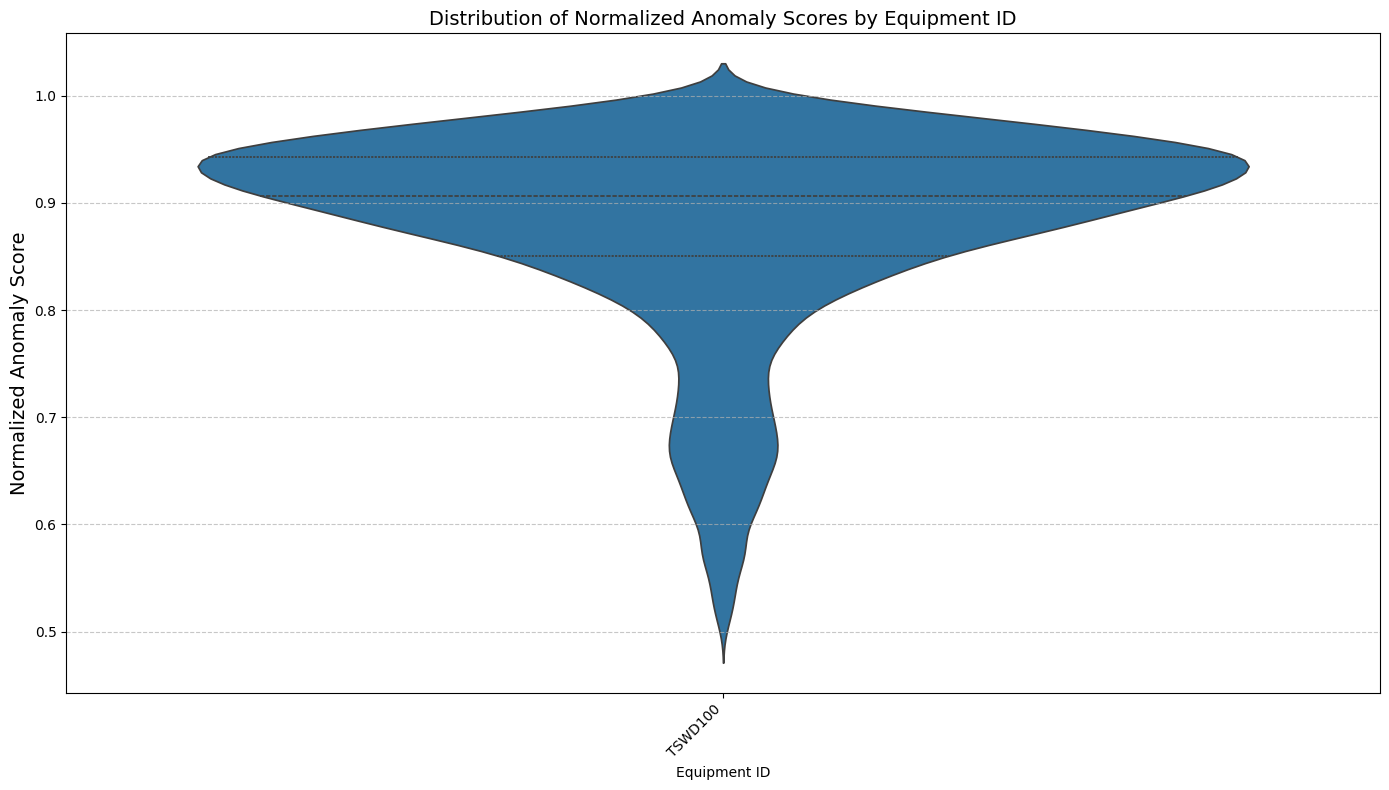

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style and size
plt.figure(figsize=(14, 8))

# Create violin plot (shows distribution density)
sns.violinplot(
    x='EquipID',
    y='AnomalyScore_normalized',
    data=anomalies_df,
    inner='quartile'  # Adds quartile lines inside the violin
)

# Improve readability
plt.title('Distribution of Normalized Anomaly Scores by Equipment ID', fontsize=14)
plt.xlabel('Equipment ID', fontsize=10)
plt.ylabel('Normalized Anomaly Score', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

# Add gridlines for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [12]:
dfx.tail(3)

,EquipID,Recipe,CreateTime,CreateTimeUnix,EventDesc,SAW_ProductionStock_Z1,BladeOD_Z1,BladeThickness_Z1,FlangeODType_Z1,SAW_ProductionStock_Z2,...,SVID_1503,SVID_1760,SVID_1759,SVID_1755,SVID_1756,SVID_1500,SVID_1501,SVID_1785,SVID_1764,SVID_1766
9983,TSWD100,ONS2210P_C_1,2025-04-03 23:58:46.580,1743724726,Kerf Check Start,SW00000109,2.1874,0.0012,Hub,SW00000150,...,1110,206,205,127,125,49960,49960,483,49960,50000
9984,TSWD100,ONS2210P_C_1,2025-04-03 23:58:56.520,1743724736,Kerf Check End,SW00000109,2.1874,0.0012,Hub,SW00000150,...,1130,207,205,128,126,49960,49960,499,49960,49960
9985,TSWD100,ONS2210P_C_1,2025-04-03 23:59:54.837,1743724794,Kerf Check Start,SW00000109,2.1874,0.0012,Hub,SW00000150,...,1130,207,205,127,126,49960,49960,483,49960,49960


In [13]:
anomalies_df.tail(3)

,AnomalyScore,AnomalyScore_normalized,CreateTime,CreateTimeUnix,EquipID,Recipe,EventDesc,SAW_ProductionStock_Z1,BladeOD_Z1,BladeThickness_Z1,...,SVID_1503,SVID_1760,SVID_1759,SVID_1755,SVID_1756,SVID_1500,SVID_1501,SVID_1785,SVID_1764,SVID_1766
9983,0.041513,0.578183,2025-04-03 23:58:46.580,1743724726,TSWD100,ONS2210P_C_1,Kerf Check Start,SW00000109,2.1874,0.0012,...,1110,206,205,127,125,49960,49960,483,49960,50000
9984,0.075285,0.663432,2025-04-03 23:58:56.520,1743724736,TSWD100,ONS2210P_C_1,Kerf Check End,SW00000109,2.1874,0.0012,...,1130,207,205,128,126,49960,49960,499,49960,49960
9985,0.092308,0.706402,2025-04-03 23:59:54.837,1743724794,TSWD100,ONS2210P_C_1,Kerf Check Start,SW00000109,2.1874,0.0012,...,1130,207,205,127,126,49960,49960,483,49960,49960


In [14]:
anomalies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9464 entries, 0 to 9985
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   AnomalyScore             9464 non-null   float64       
 1   AnomalyScore_normalized  9464 non-null   float64       
 2   CreateTime               9464 non-null   datetime64[ms]
 3   CreateTimeUnix           9464 non-null   int64         
 4   EquipID                  9464 non-null   object        
 5   Recipe                   9464 non-null   object        
 6   EventDesc                9464 non-null   object        
 7   SAW_ProductionStock_Z1   9464 non-null   object        
 8   BladeOD_Z1               9464 non-null   object        
 9   BladeThickness_Z1        9464 non-null   object        
 10  FlangeODType_Z1          9464 non-null   object        
 11  SAW_ProductionStock_Z2   9464 non-null   object        
 12  BladeOD_Z2               9464 non-null 

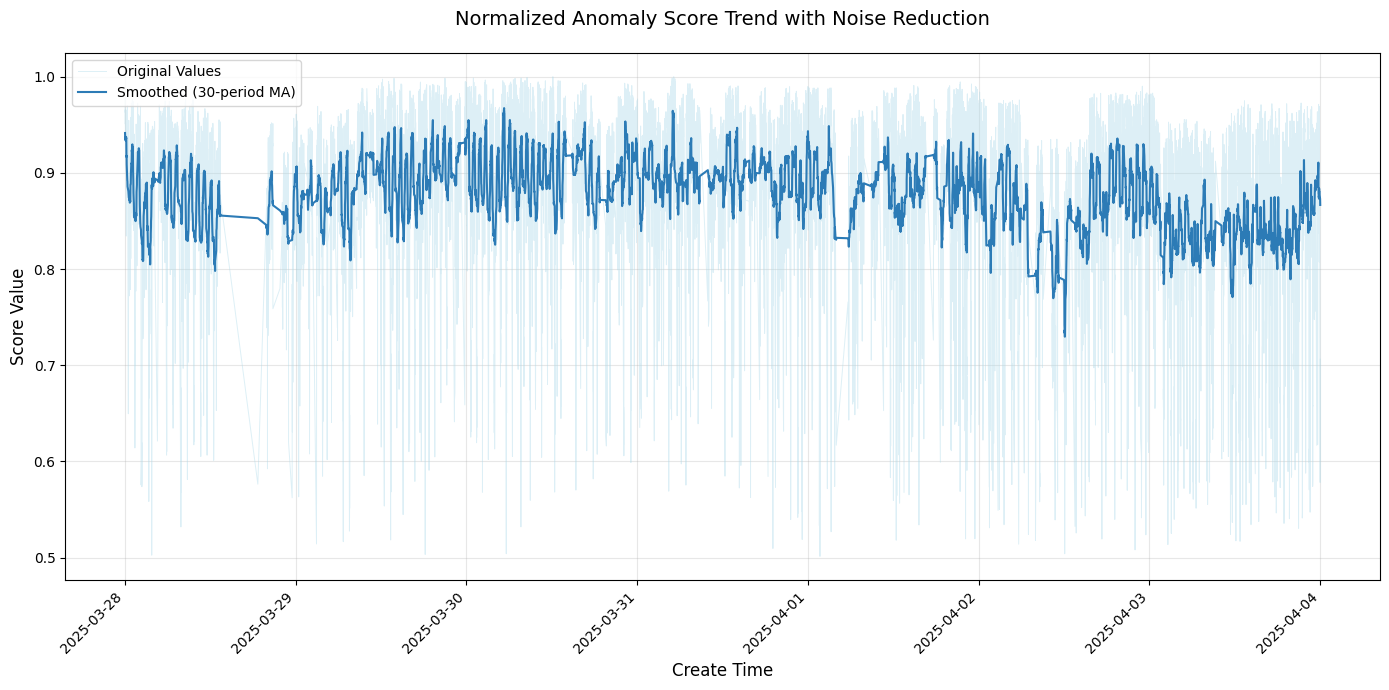

In [15]:
# Sort data and calculate moving average
df = anomalies_df.sort_values('CreateTime')
window_size = 30  # Adjust this based on your data frequency
df['AnomalyScore_smoothed'] = df['AnomalyScore_normalized'].rolling(
    window=window_size,
    min_periods=1,
    center=True
).mean()

plt.figure(figsize=(14, 7))

# Plot original data with transparency
sns.lineplot(
    data=df,
    x='CreateTime',
    y='AnomalyScore_normalized',
    color='#abd9e9',
    linewidth=0.7,
    alpha=0.4,
    label='Original Values'
)

# Plot smoothed trend line
sns.lineplot(
    data=df,
    x='CreateTime',
    y='AnomalyScore_smoothed',
    color='#2c7bb6',
    linewidth=1.5,
    label=f'Smoothed ({window_size}-period MA)'
)

plt.title('Normalized Anomaly Score Trend with Noise Reduction', fontsize=14, pad=20)
plt.xlabel('Create Time', fontsize=12)
plt.ylabel('Score Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')

# Format x-axis dates
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d')) 

plt.tight_layout()
plt.show()